# 01 Removing Negative Photon Counts

The number of photons counted by the detector should not be negative because that does not make physical sense. This notebook shows that experimental fits were not good when negative photon counts were present in the data. Fits with negative counts are excluded from the data in subsequent notebooks.

In [21]:
import h5py
import pyxrfmaps as px 
import numpy as np
import matplotlib.pyplot as plt

In [22]:
element_csv_filename = "../reference/xrf_library.csv"
element_henke_filename = "../reference/henke.xdr"
input_filename = "../../2die_2012_2017.hdf5"

In [23]:
# Initial set up for XRF Maps
px.load_element_info(element_henke_filename, element_csv_filename)
trans = px.io.file.get_FILE_TAGS_TRANSLATION()
fit_rout = px.fitting.routines.nnls()

## Plotting the Fits

Plots show the poor quality of fits with negative photon counts. This cell can be stopped early to prevent a long time spent plotting.

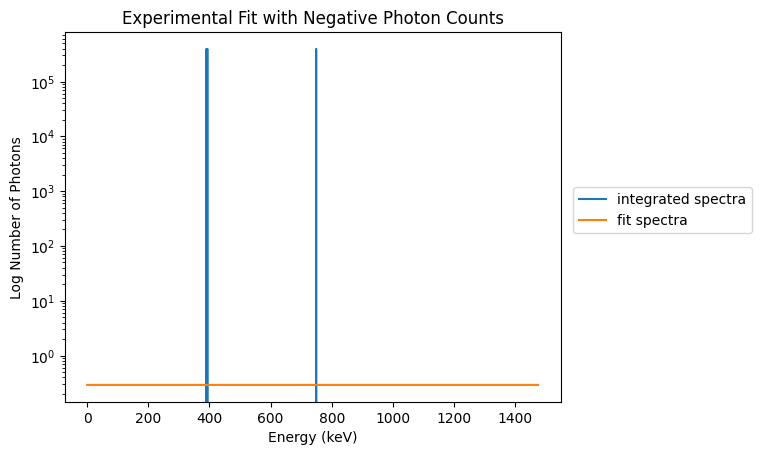

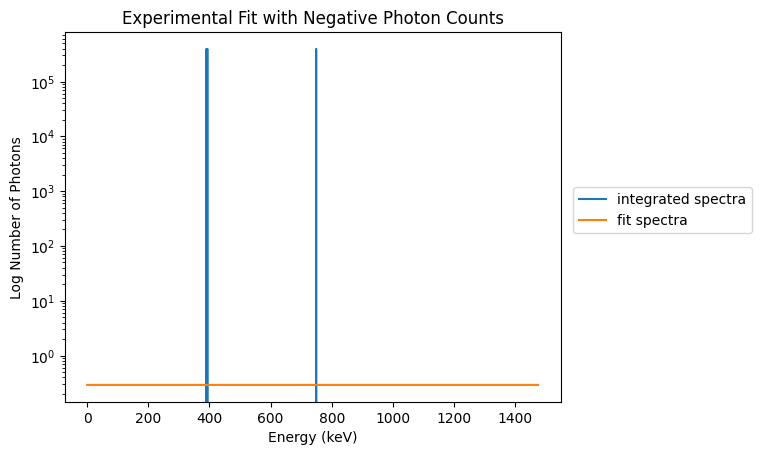

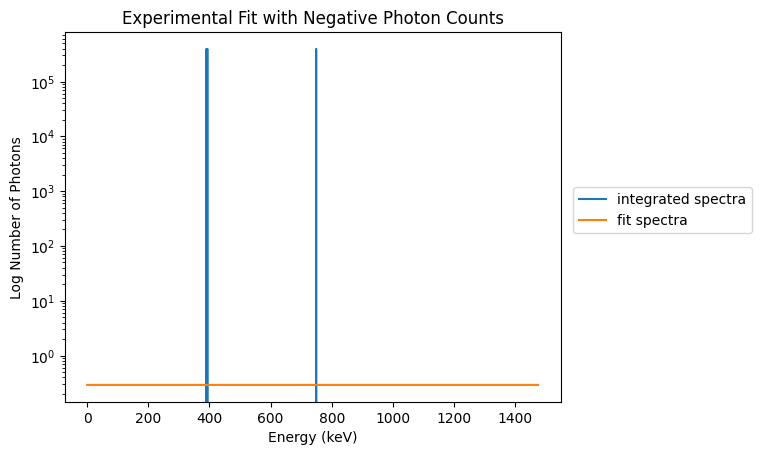

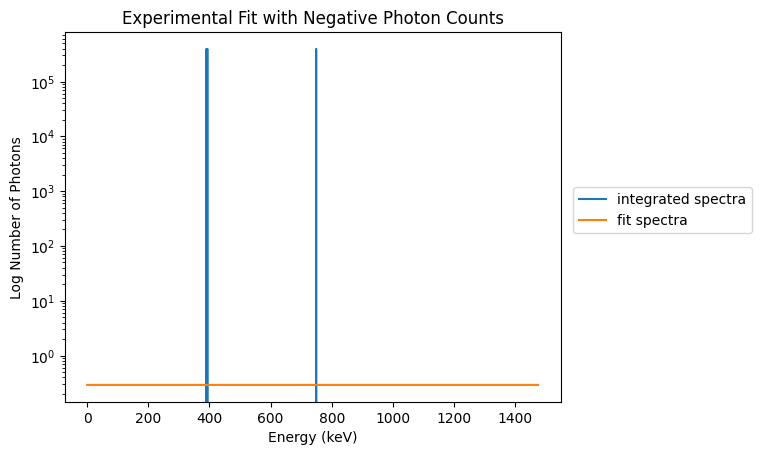

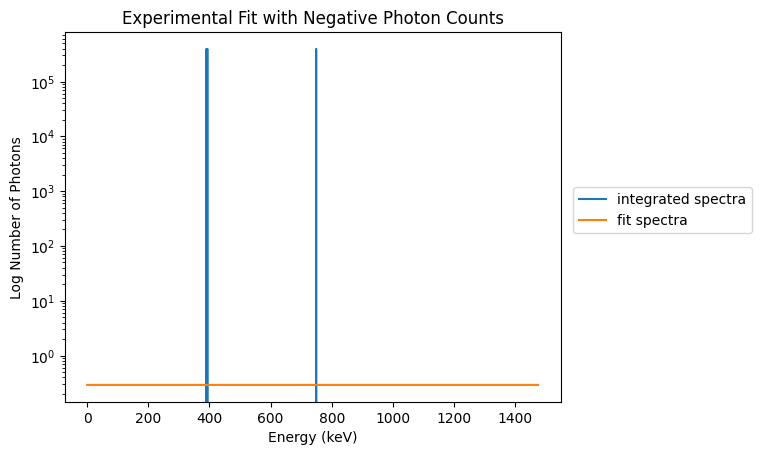

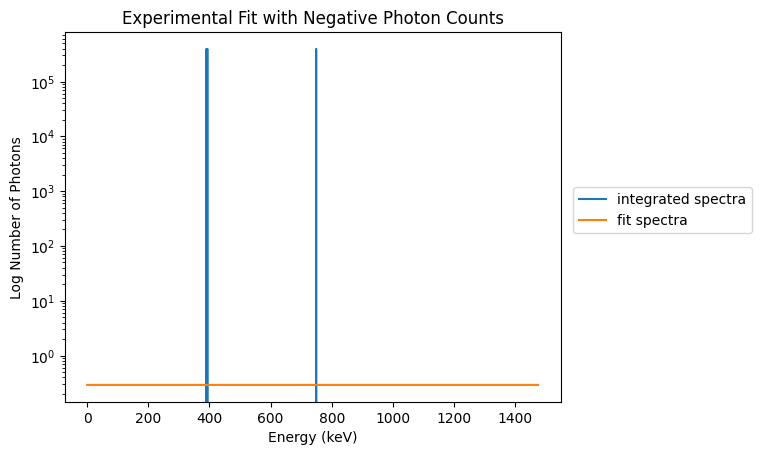

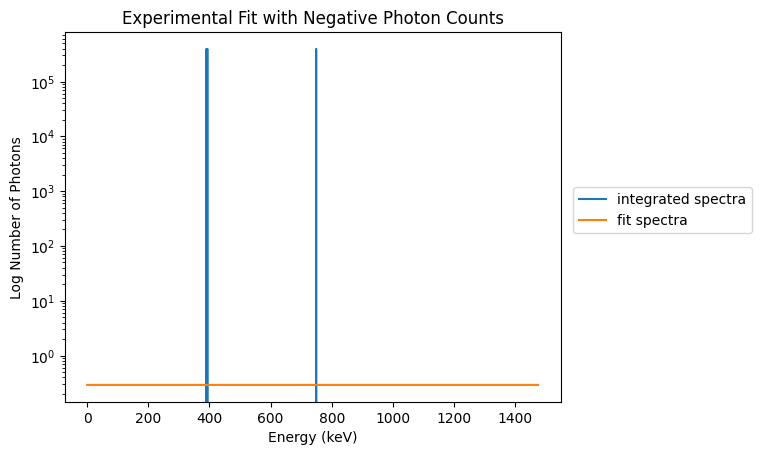

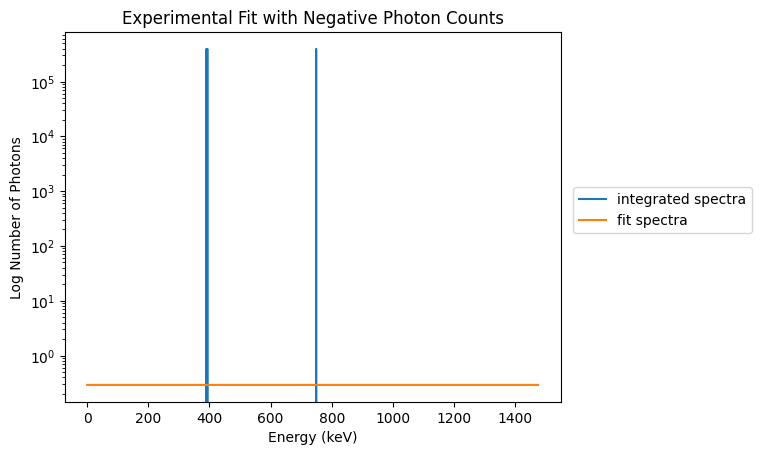

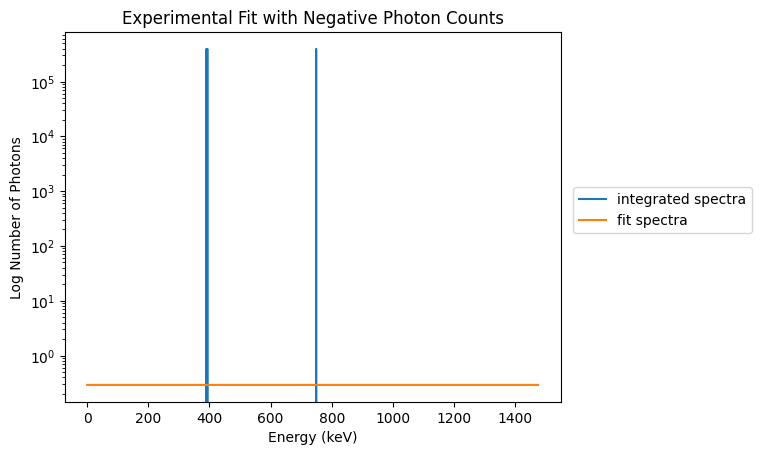

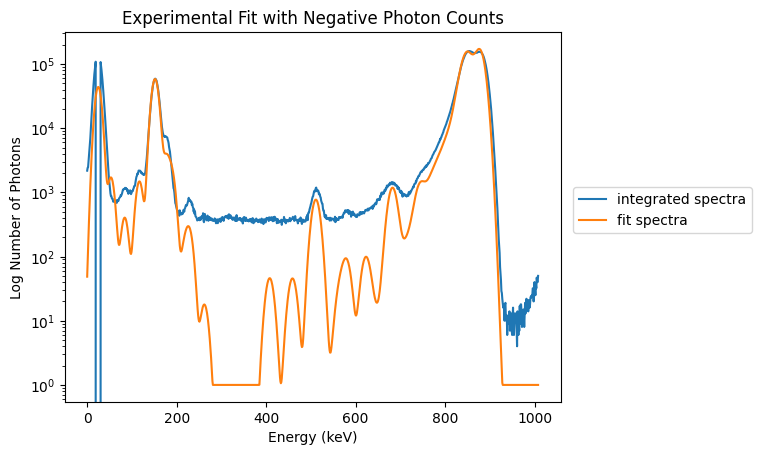

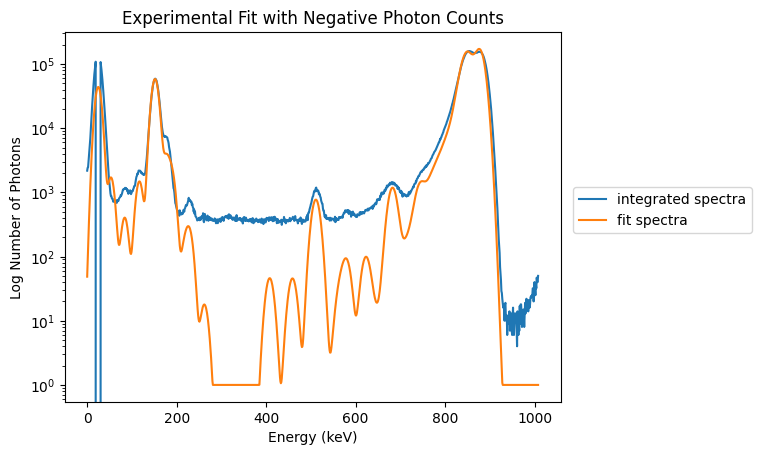

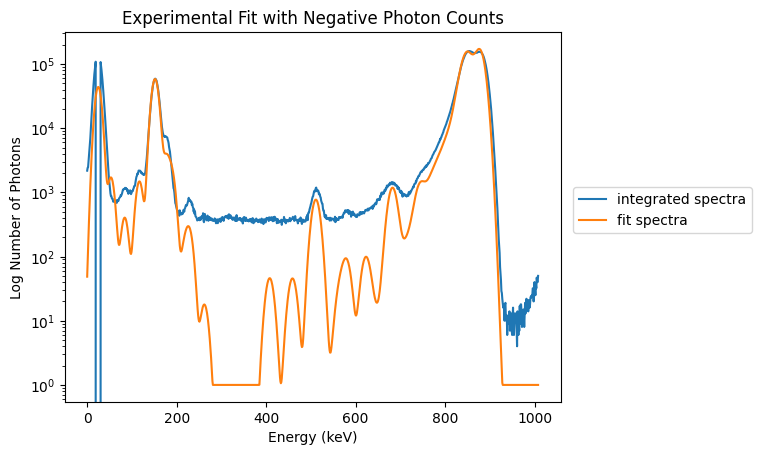

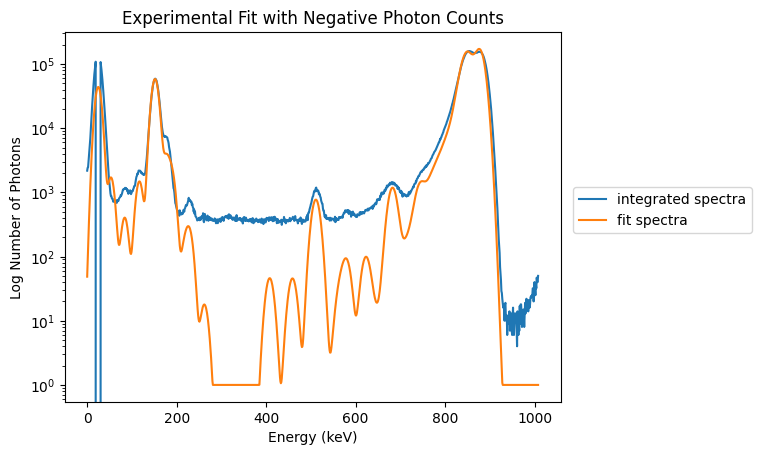

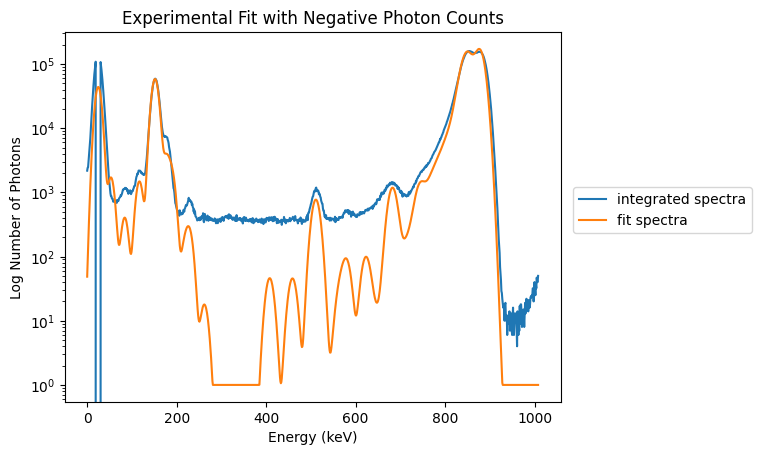

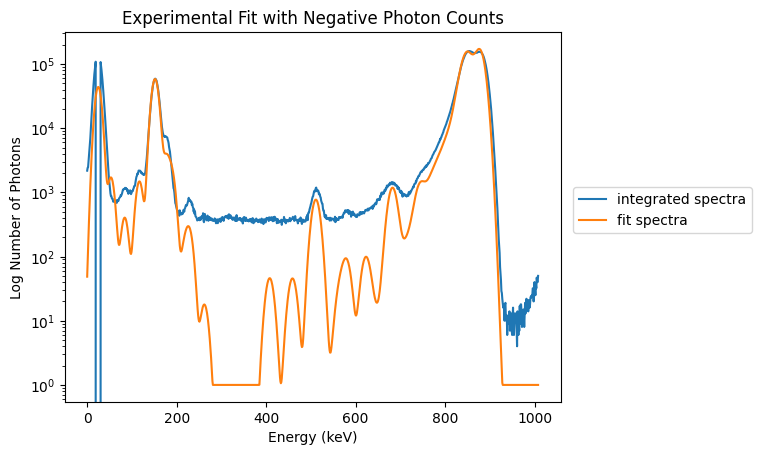

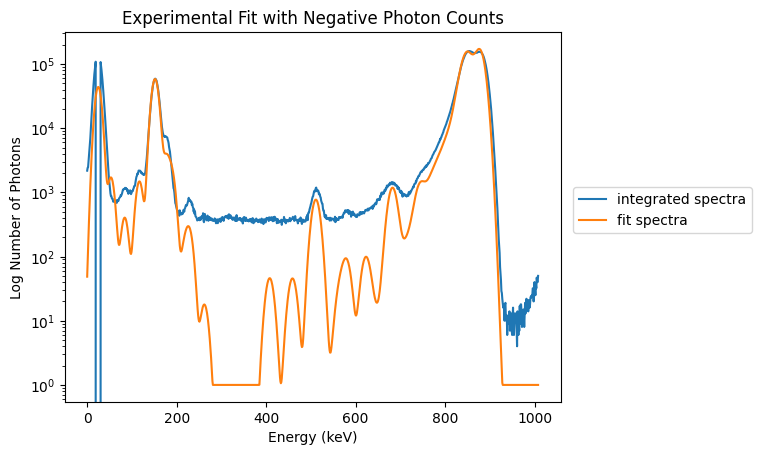

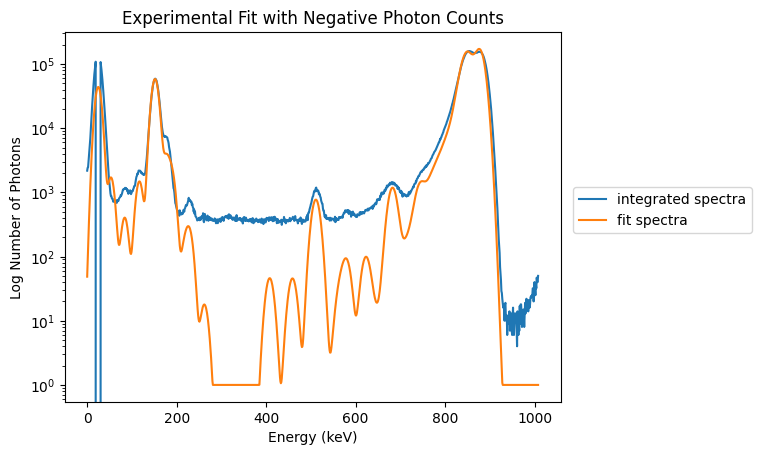

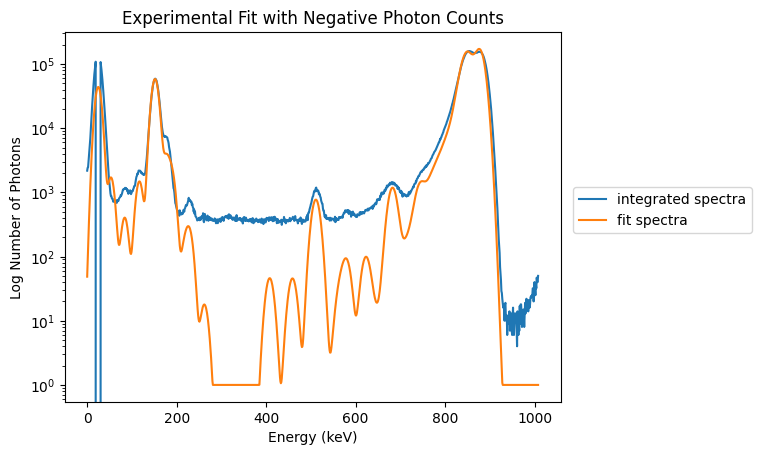

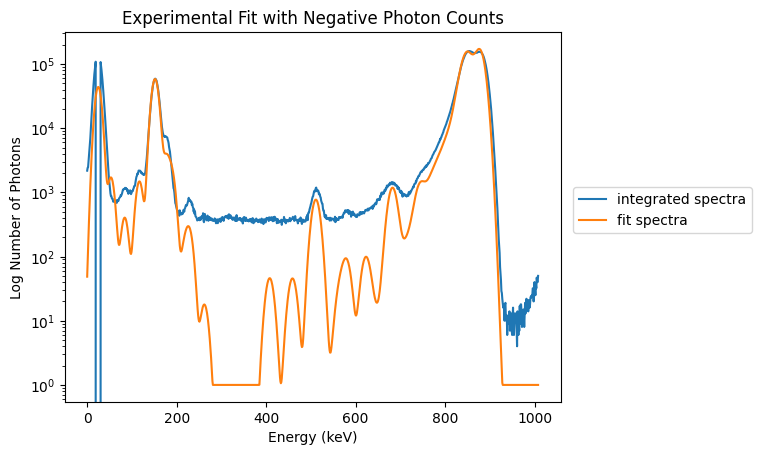

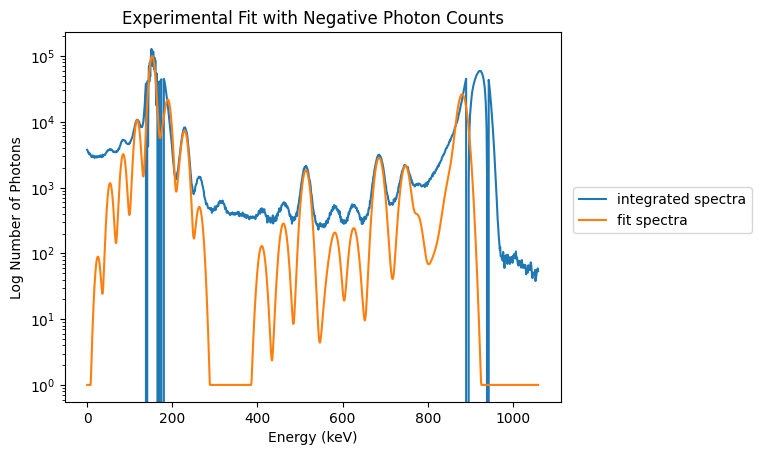

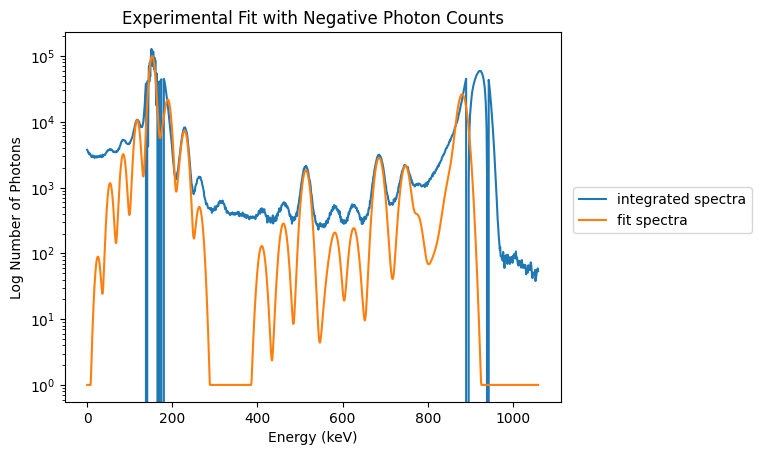

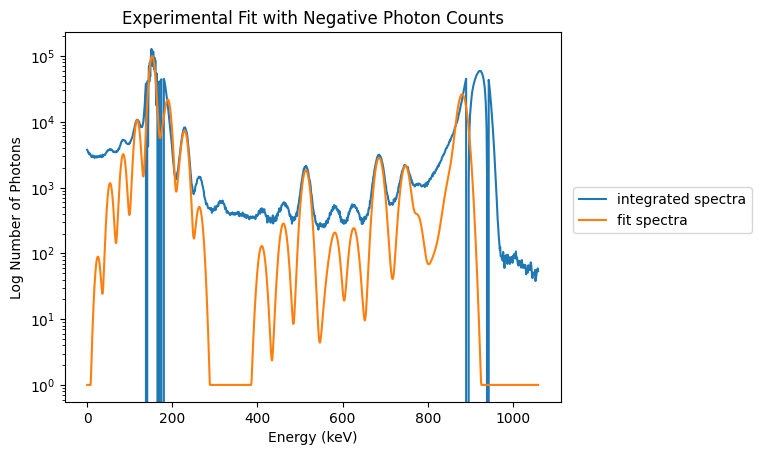

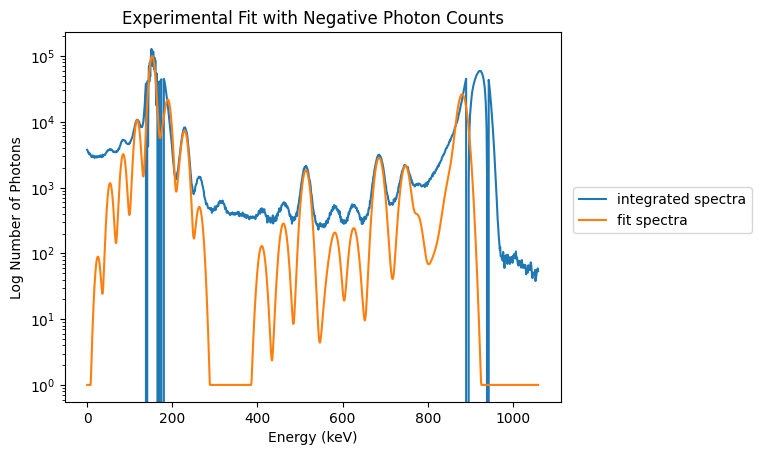

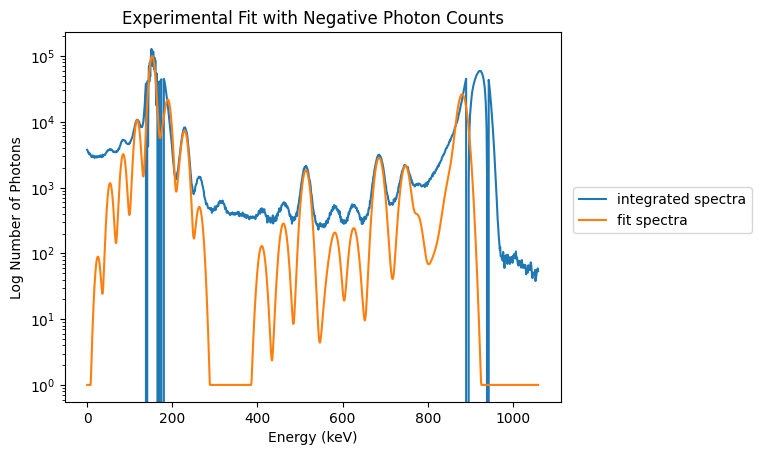

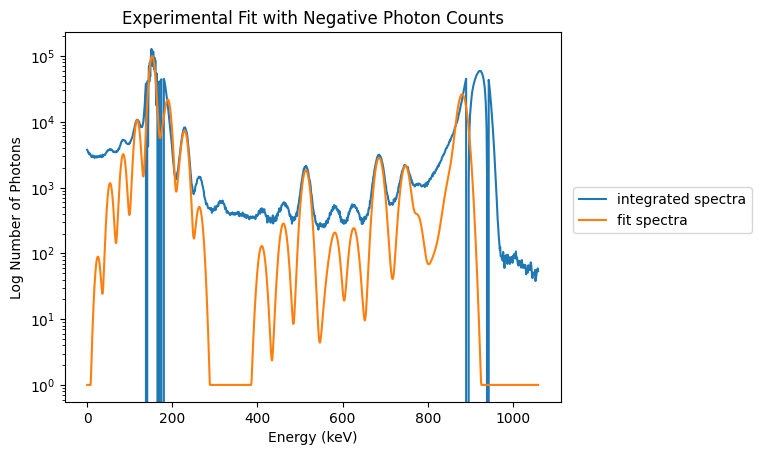

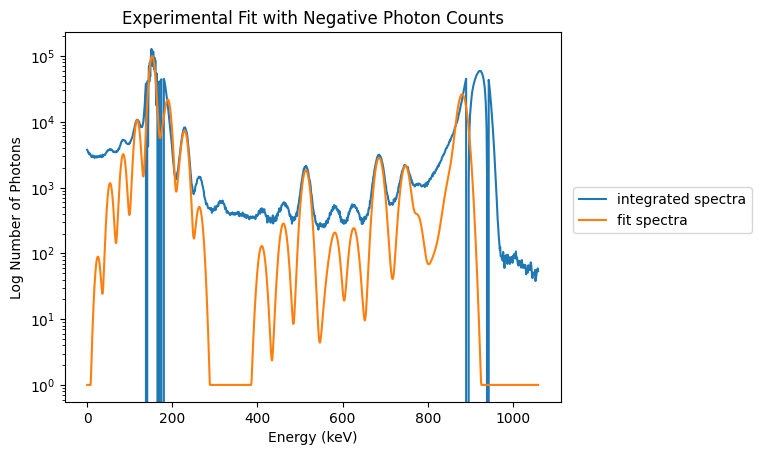

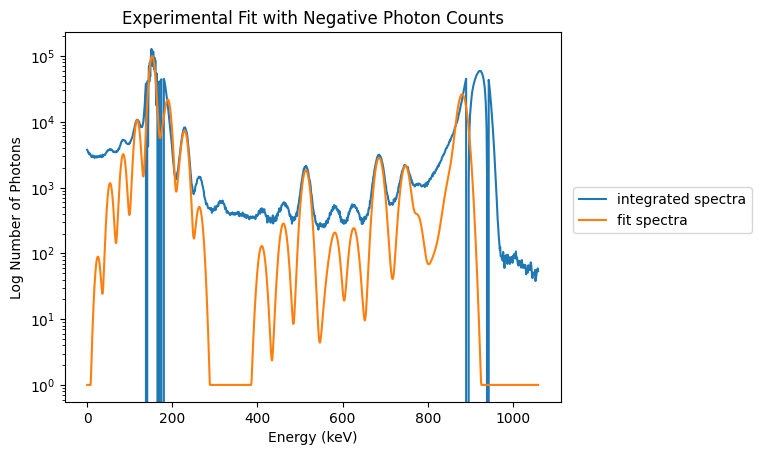

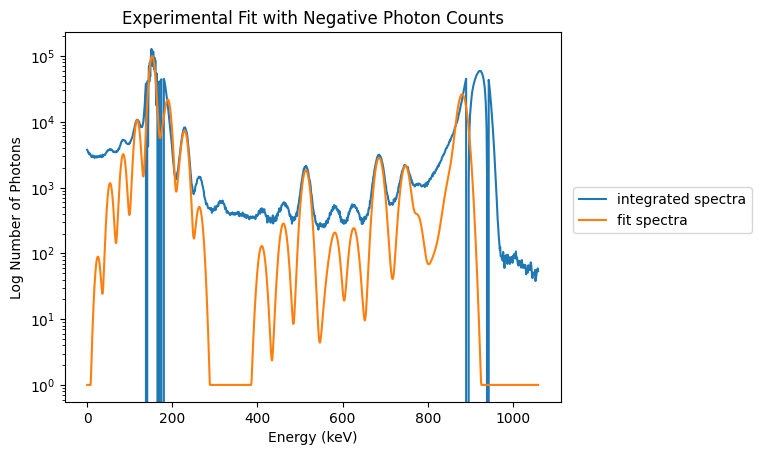

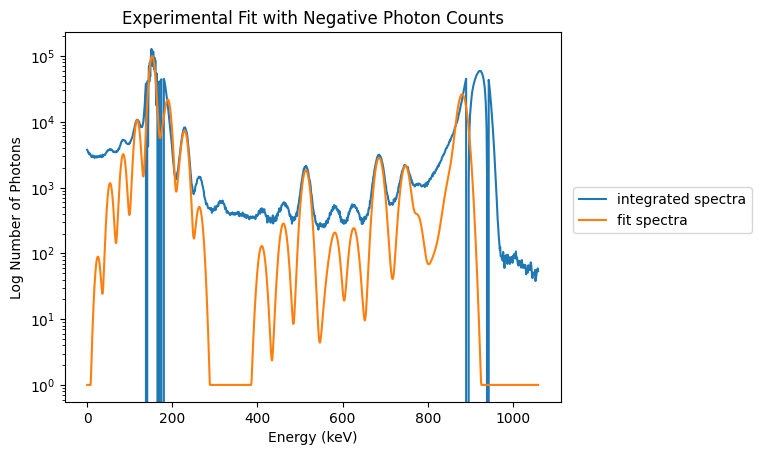

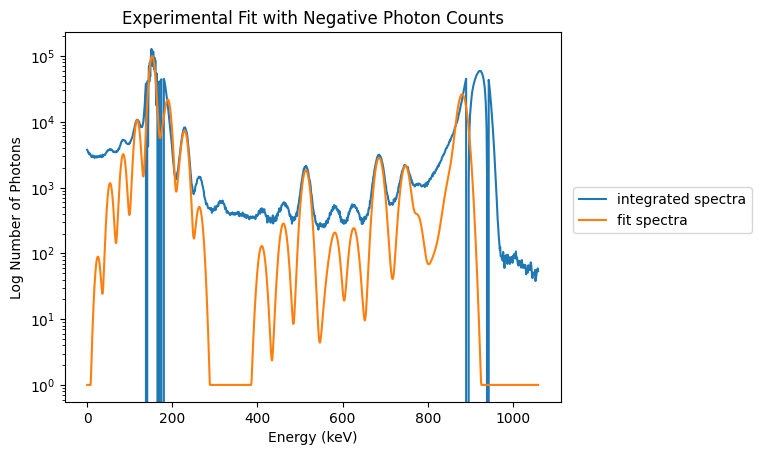

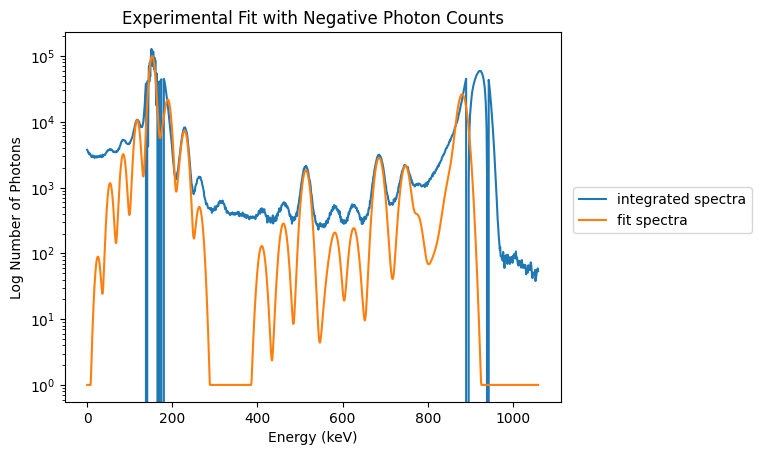

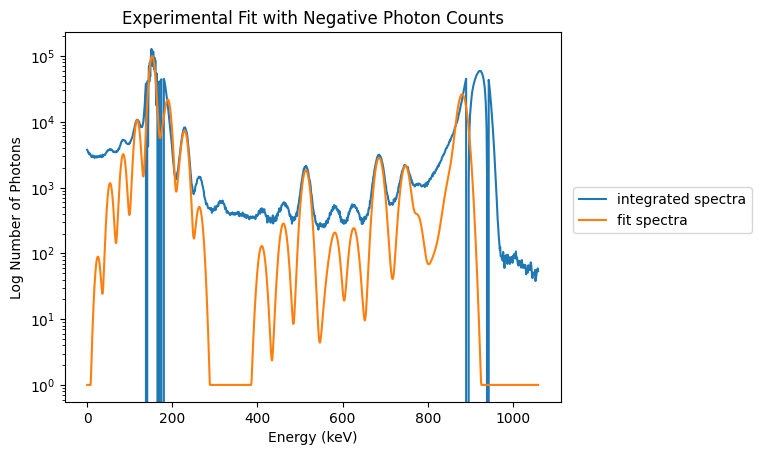

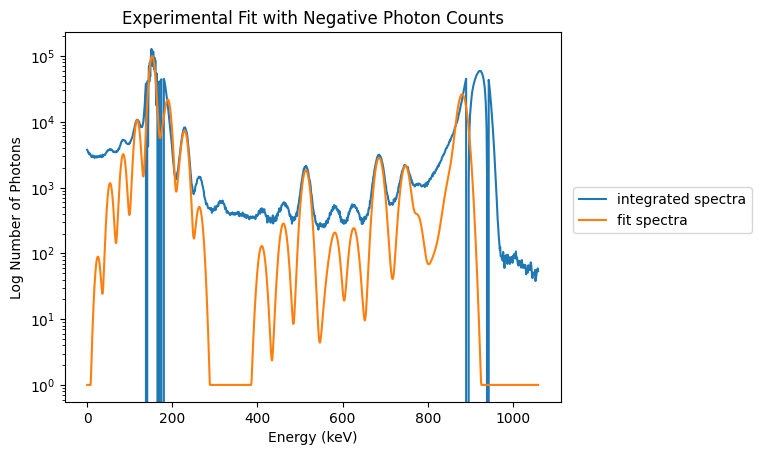

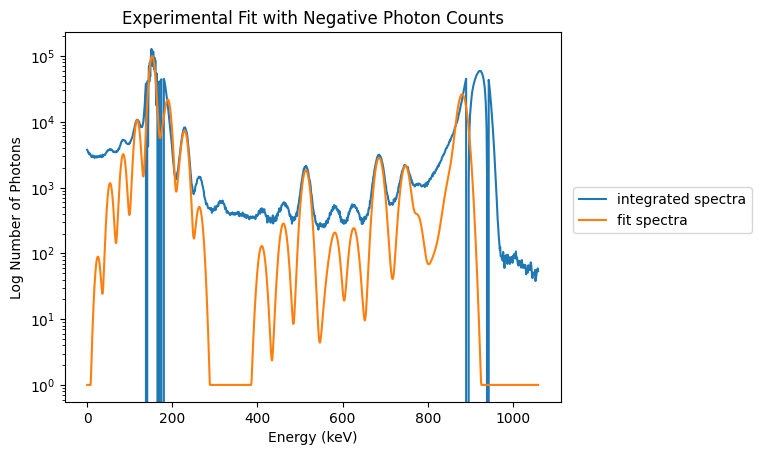

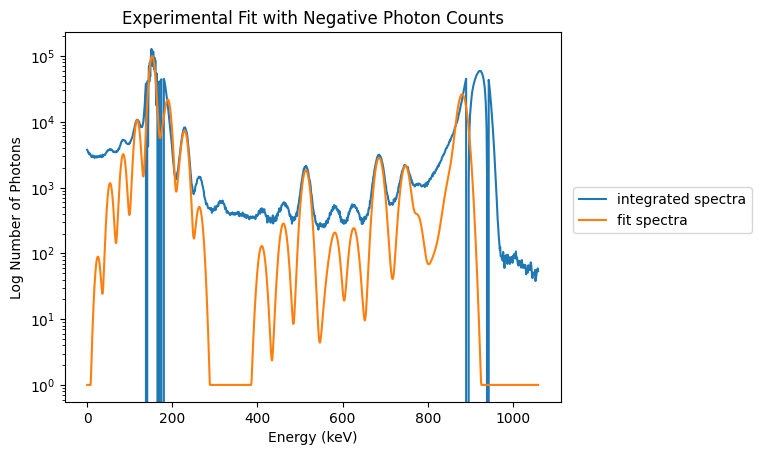

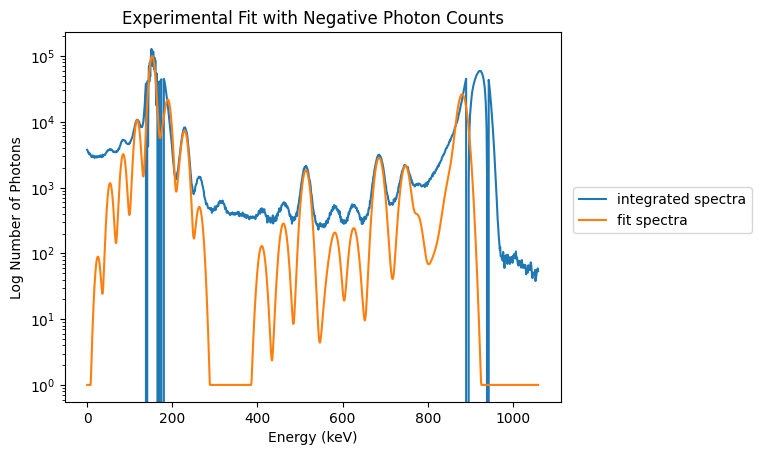

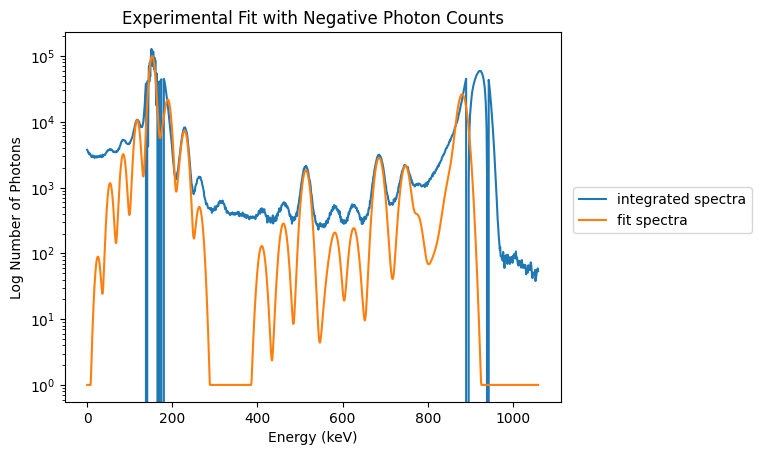

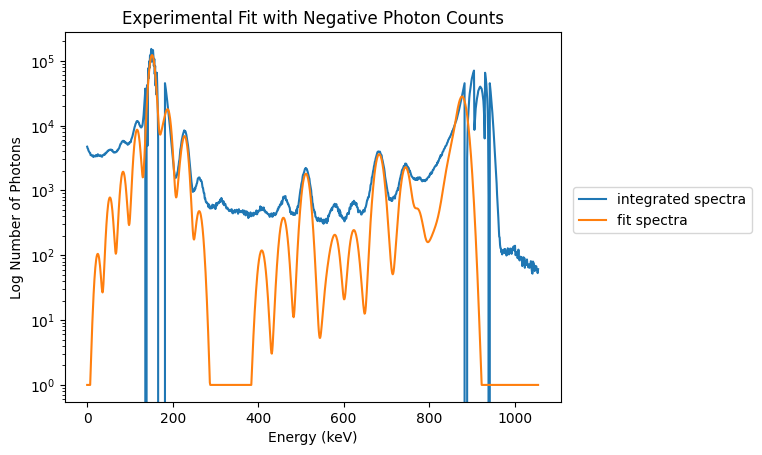

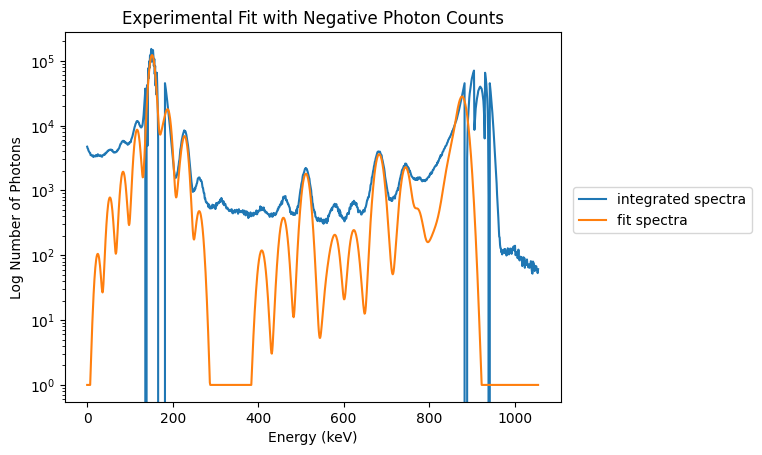

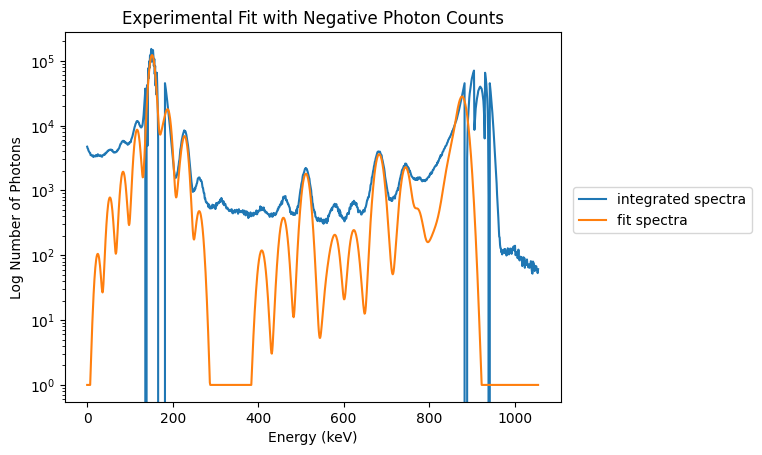

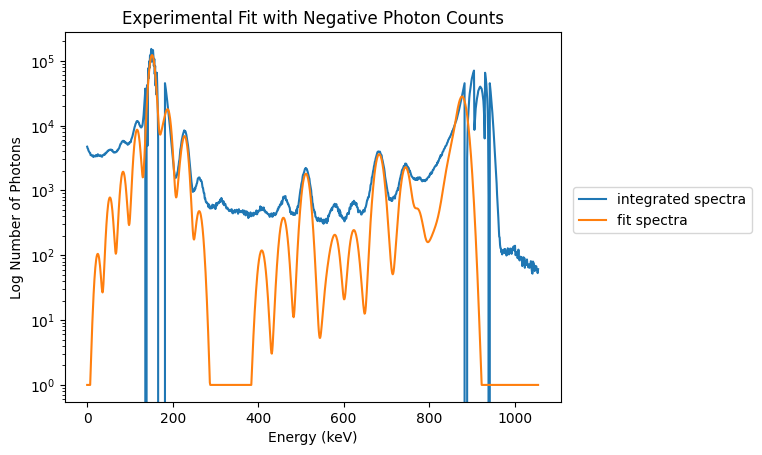

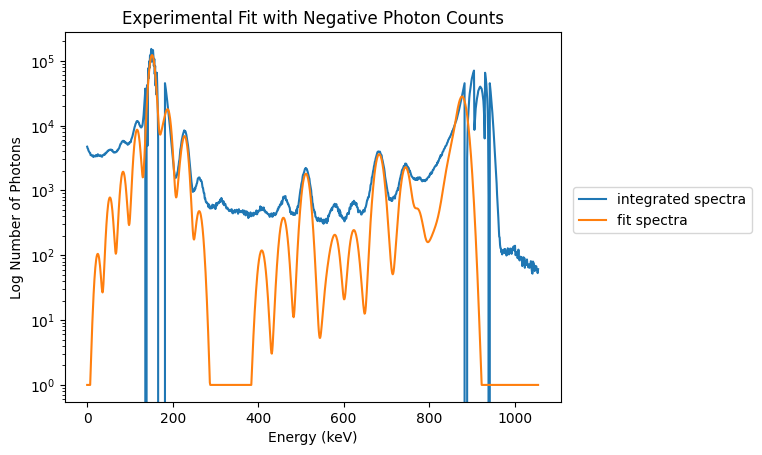

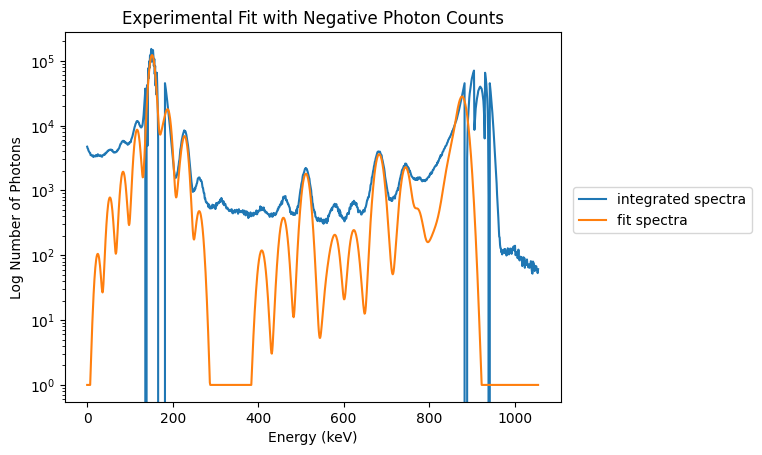

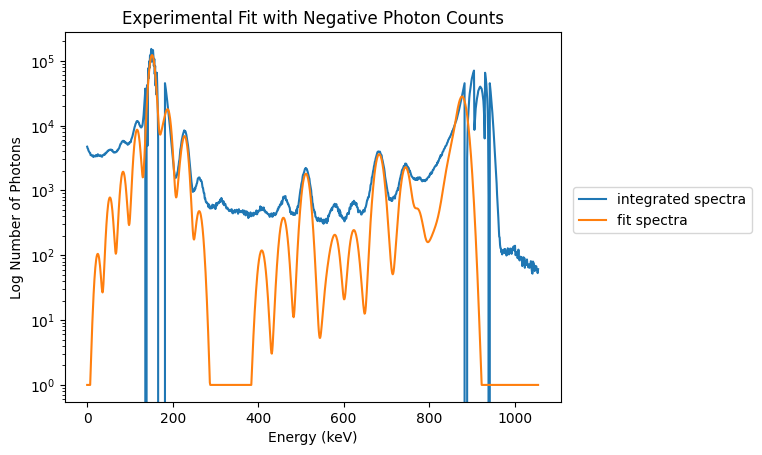

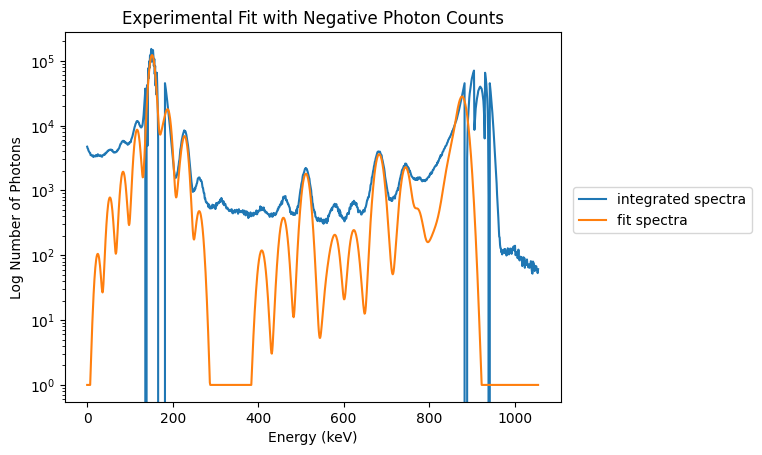

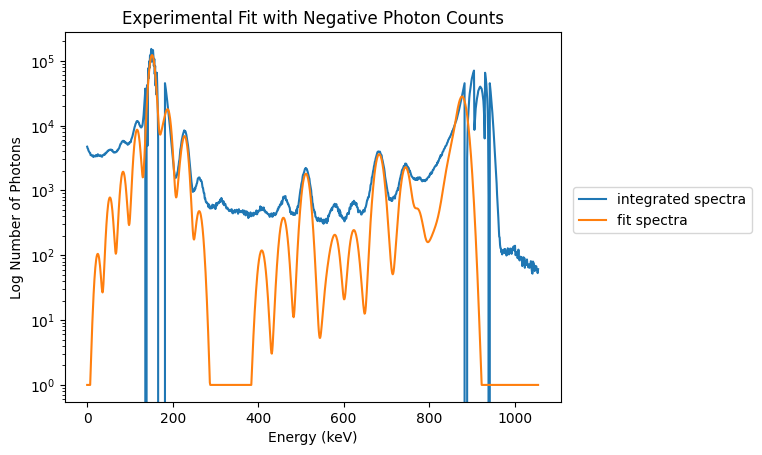

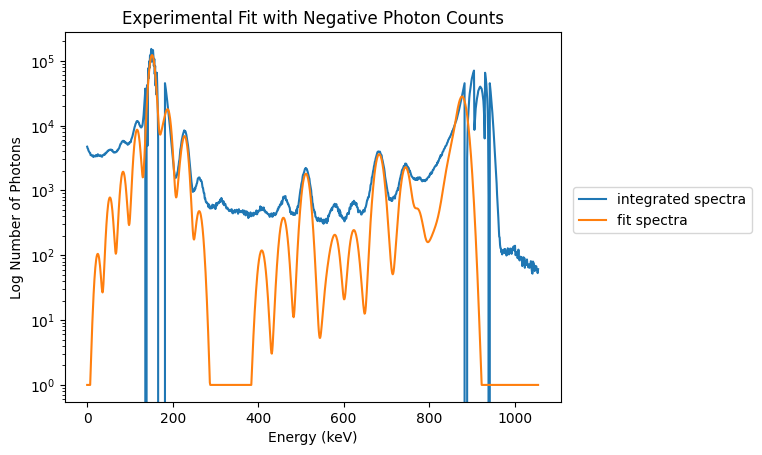

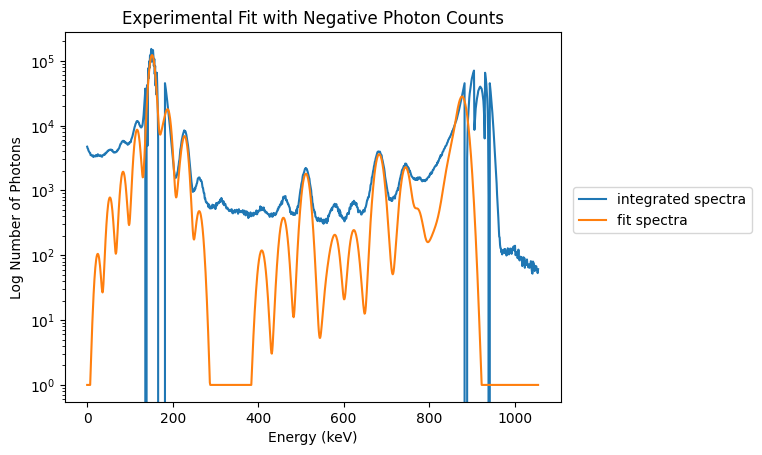

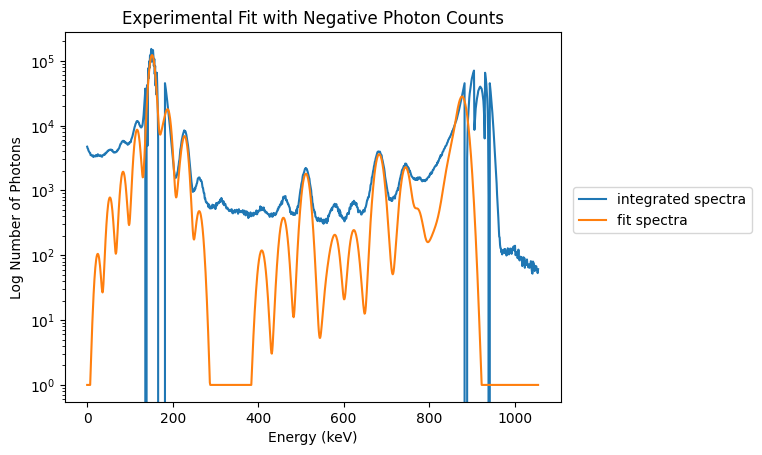

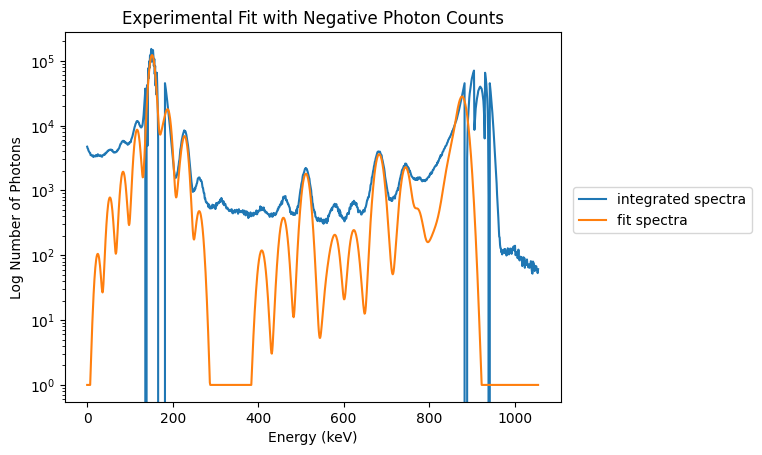

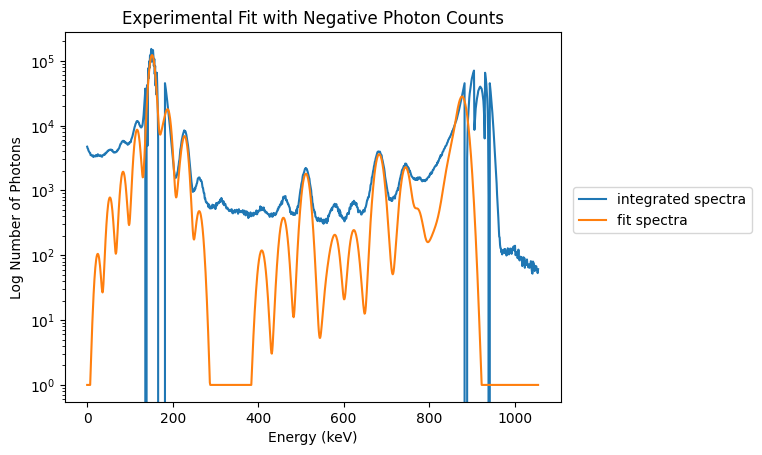

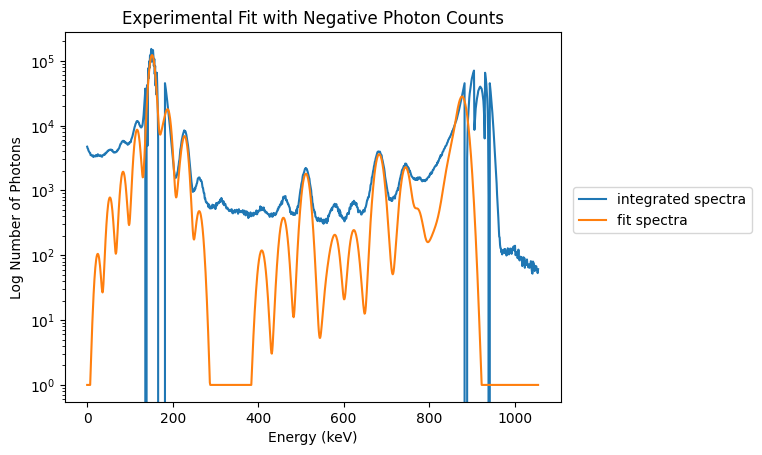

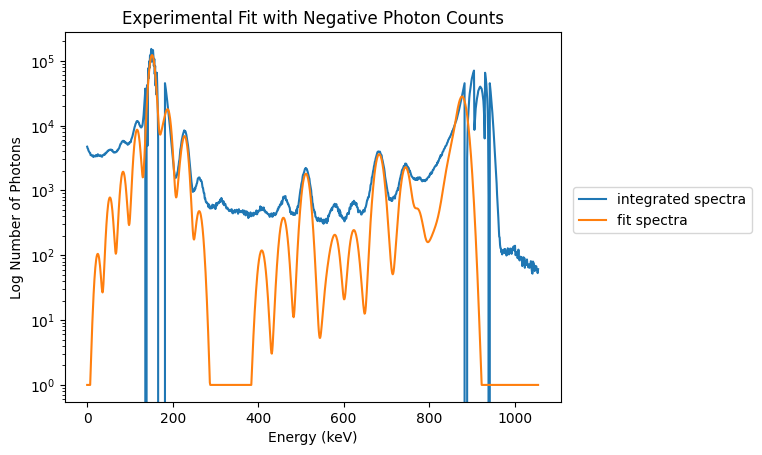

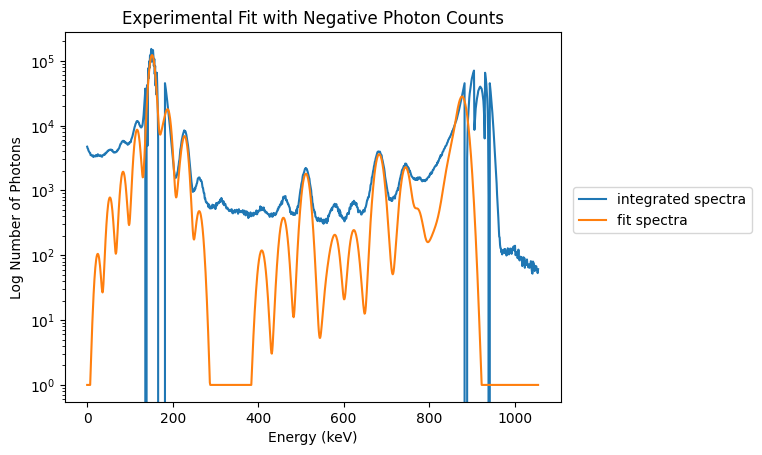

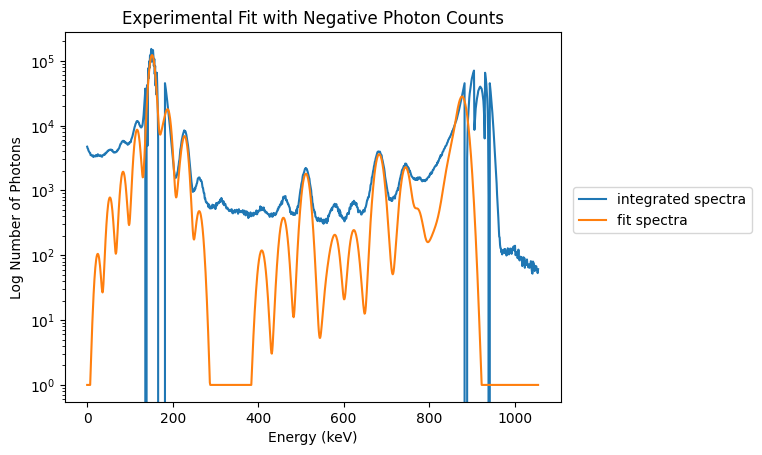

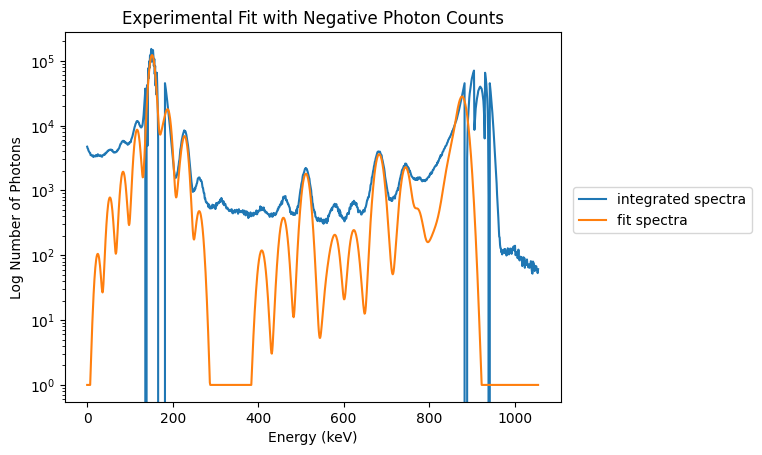

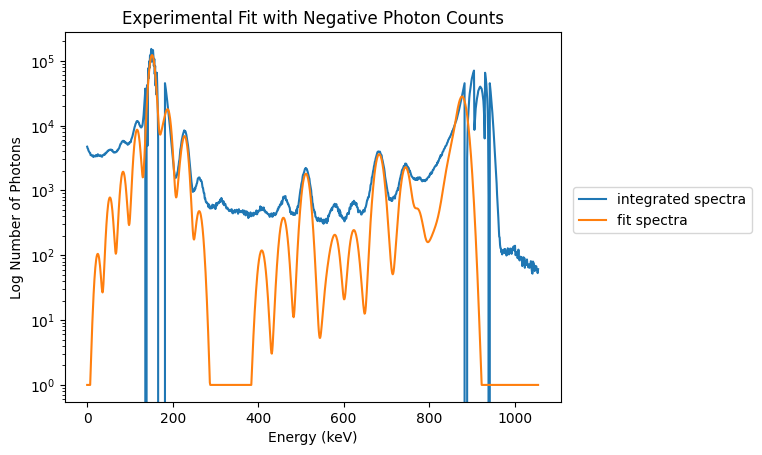

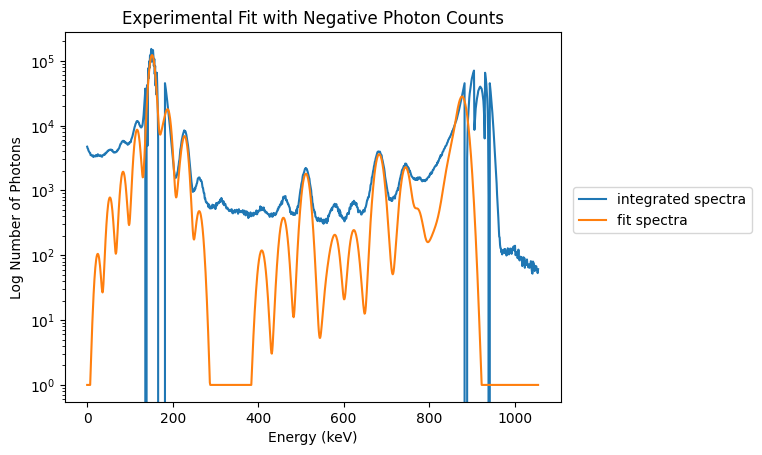

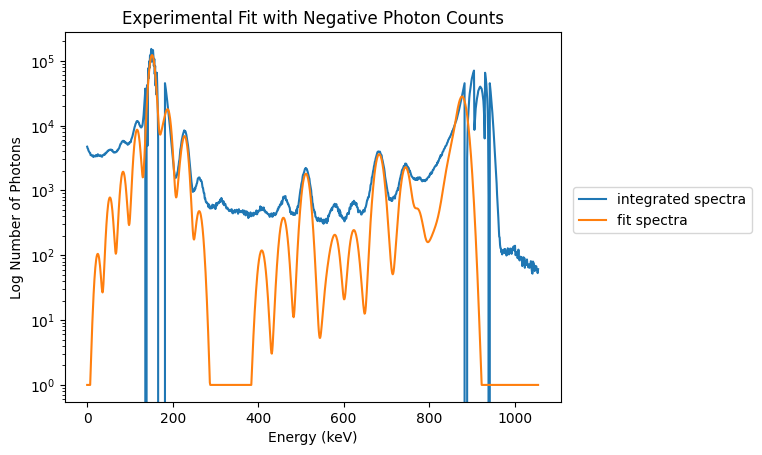

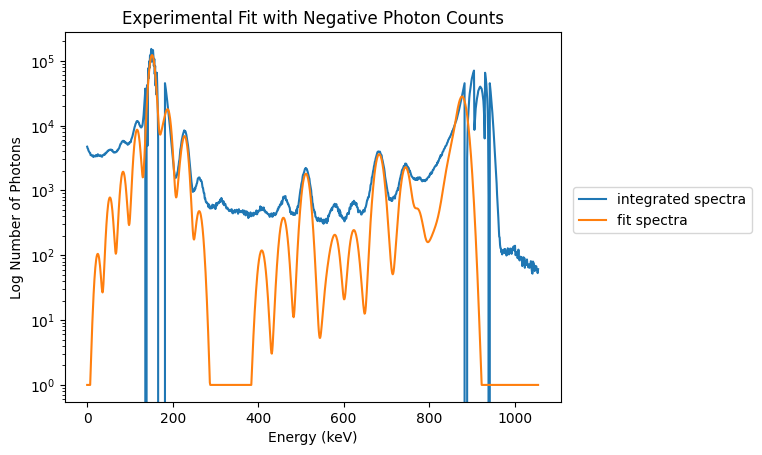

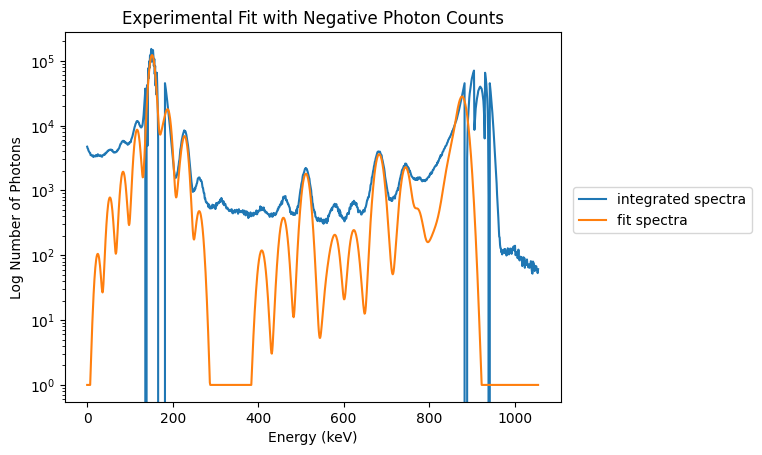

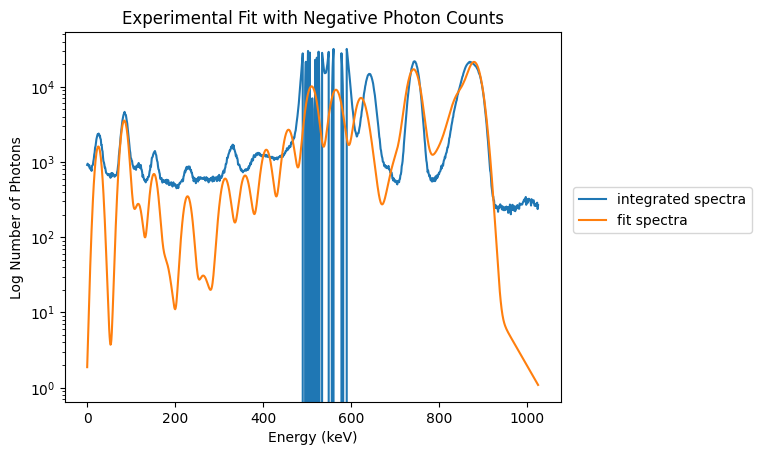

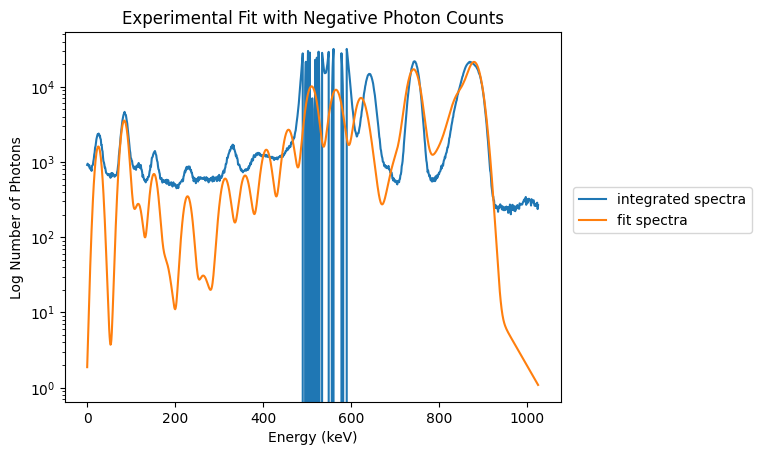

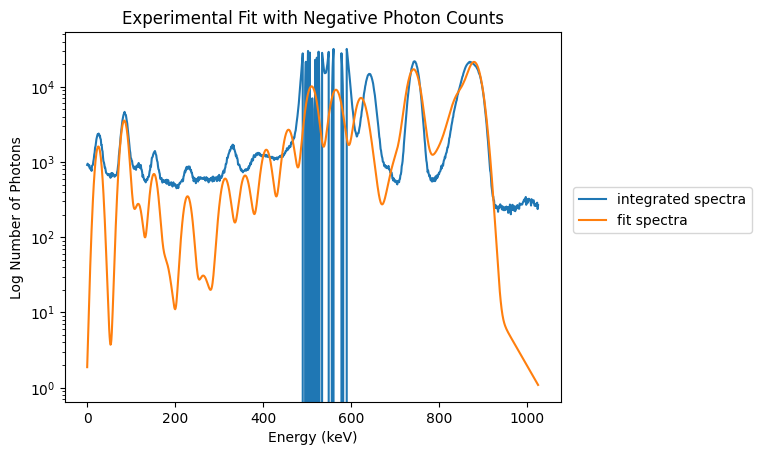

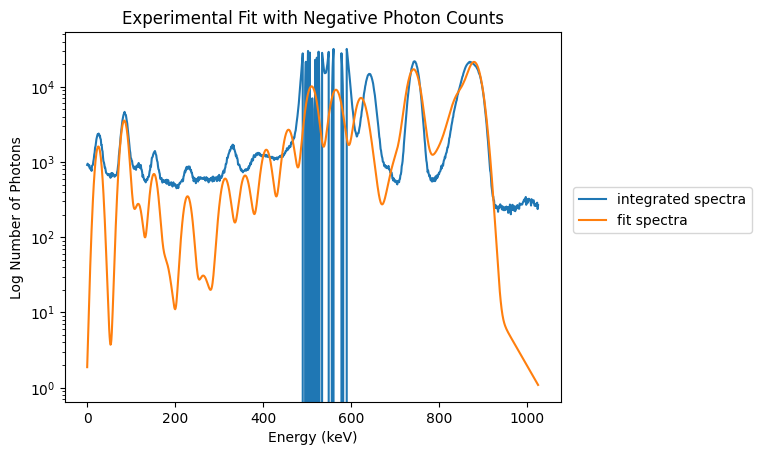

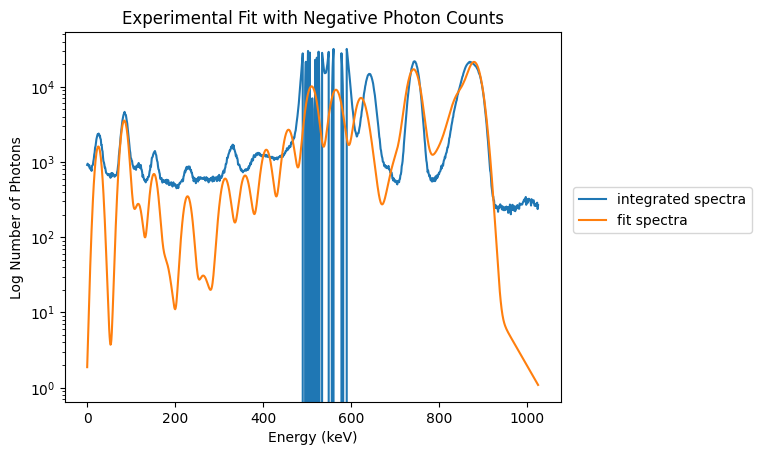

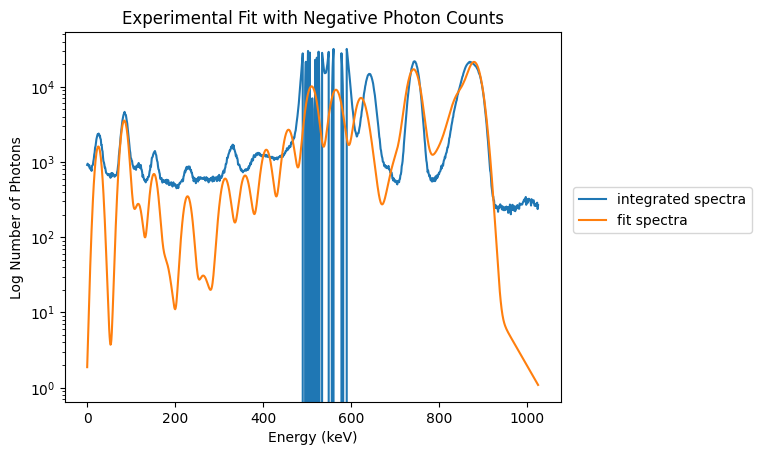

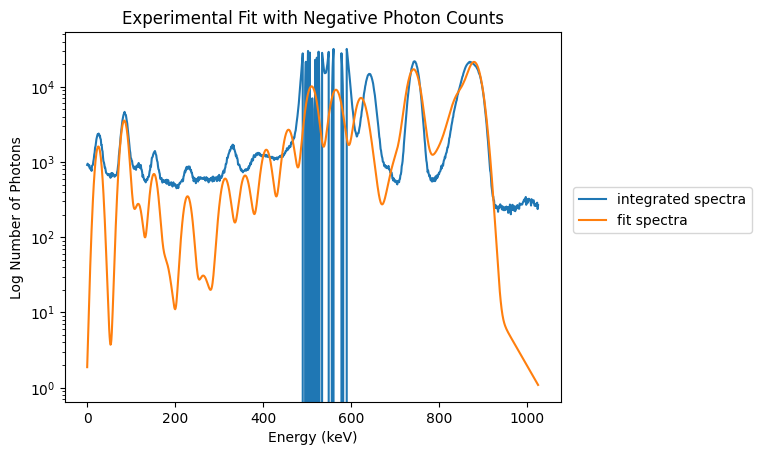

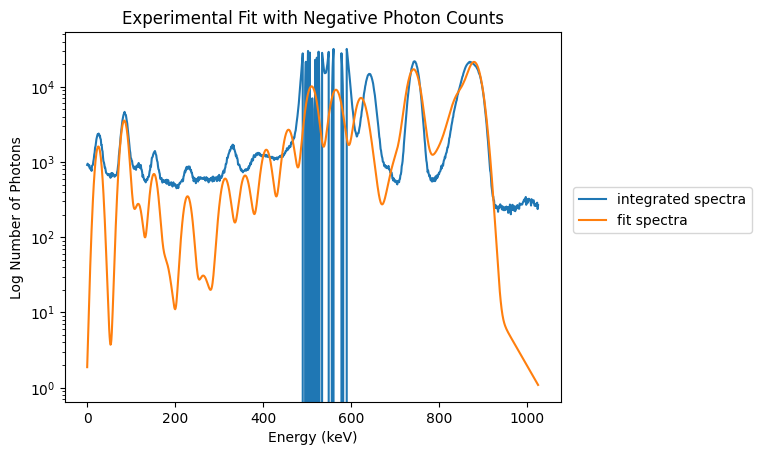

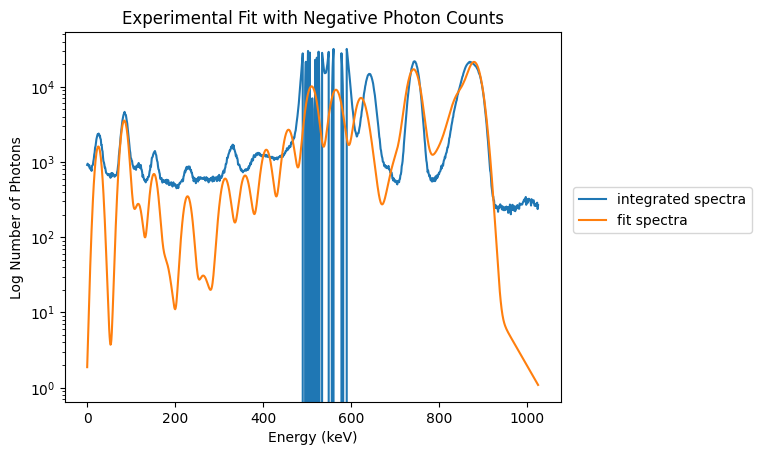

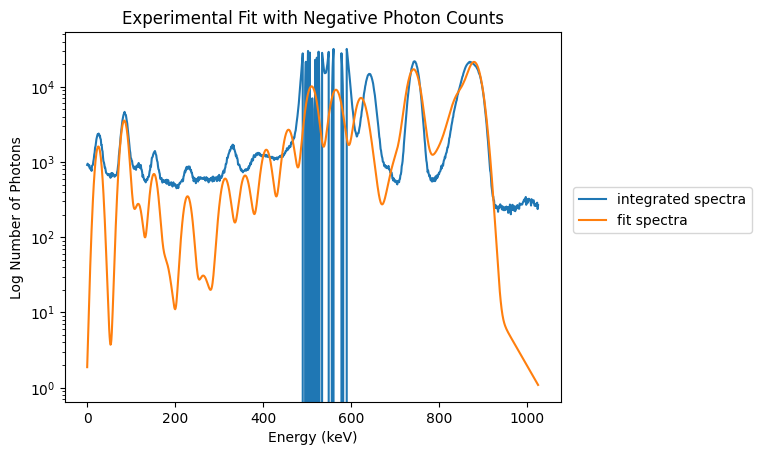

KeyboardInterrupt: 

In [24]:
with h5py.File(input_filename, 'r') as infile:
    for name, h5obj in infile.items():
        # Load dataset
        int_specs = h5obj['int_spectra']
        # Initialize model and fit routine with fit parameters
        for spectra in int_specs:
            for v in spectra:
                if v < 0:
                    # Use Gausian Model
                    model = px.fitting.models.GaussModel()
                    po = px.ParamsOverride()
                    
                    el = h5obj['elements'][()]
                    el = el.decode()        
                    el_list = [i.strip() for i in el.split(',')]
                    el_list += ['COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE']
   
                    po.fill_elements_from_dict(el_list, 'Si')
                    param_names = h5obj['fit_param_names'][...]
                    param_values = h5obj['fit_param_values'][...]
                    for name, value in zip(param_names, param_values):
                        name = name.decode()
                        if name in trans:
                            name = trans[name]
                        po.fit_params.add_parameter(px.Fit_Param(name, value))
                    model.update_fit_params_values(po.fit_params)
            
                    energy_range = px.get_energy_range(spectra.size, po.fit_params)
                    fit_rout.initialize(model, po.elements_to_fit, energy_range)

                    # Get Fit Spectra 
                    fit_spec = fit_rout.fit_spectra(model, spectra, po.elements_to_fit)
                    max_val = np.amax(fit_spec)
                    fit_spec = np.clip(fit_spec, 1, max_val)
                    # Resize int_spec to match fit_spec
                    resize_spectra = spectra[energy_range.min:energy_range.max+1]
                    
                    i_ax = np.linspace(0, resize_spectra.size-1, resize_spectra.size)
                    f_ax = np.linspace(0, fit_spec.size-1, fit_spec.size)
                    fig, axs = plt.subplots()
                    axs.plot(i_ax, resize_spectra, label="integrated spectra")
                    axs.set_yscale('log')
                    axs.set_ylabel('Log Number of Photons')
                    axs.set_xlabel('Energy (keV)')
                    axs.set_title("Experimental Fit with Negative Photon Counts")
                    axs.plot(f_ax, fit_spec, label="fit spectra")
                    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.6))
                    plt.show()

## Filtering the Dataset

Data is filtered to remove experiments with negative photon counts and saved to csv files. 
It is important to maintain the order the rows are written as the spectra in each row are related to the fit parameters and elements of the same row.

In [15]:
all_int_spectra = []
all_resize_spectra = []
all_fit_spectra = []
all_fit_params = []
all_element_counts = []
all_element_names = set()
all_fit_param_names = set()
with h5py.File(input_filename, 'r') as infile:
    for name, h5obj in infile.items():
        # Load dataset
        int_specs = h5obj['int_spectra']
        # Initialize model and fit routine with fit parameters
        for spectra in int_specs:
            no_negatives = True
            for photon_count in spectra:
                if photon_count < 0:
                    no_negatives = False
            if no_negatives:
                # Use Gausian Model
                model = px.fitting.models.GaussModel()
                po = px.ParamsOverride()
                
                el = h5obj['elements'][()]
                el = el.decode()        
                el_list = [i.strip() for i in el.split(',')]
                el_list += ['COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE']
                for e in el_list:
                    all_element_names.add(e)
                    
                po.fill_elements_from_dict(el_list, 'Si')
                param_names = h5obj['fit_param_names'][...]
                param_values = h5obj['fit_param_values'][...]
                param_dict = {}
                for name, value in zip(param_names, param_values):
                    name = name.decode()
                    if name in trans:
                        name = trans[name]
                    all_fit_param_names.add(name)
                    param_dict[name] = value
                    po.fit_params.add_parameter(px.Fit_Param(name, value))
                model.update_fit_params_values(po.fit_params)
        
                energy_range = px.get_energy_range(spectra.size, po.fit_params)
                fit_rout.initialize(model, po.elements_to_fit, energy_range)

                # Fit element counts
                element_counts_fit = fit_rout.fit_counts(model, spectra, po.elements_to_fit)
                
                # Get Fit Spectra 
                fit_spec = fit_rout.fit_spectra(model, spectra, po.elements_to_fit)
                max_val = np.amax(fit_spec)
                fit_spec = np.clip(fit_spec, 1, max_val)
                # Resize int_spec to match fit_spec
                resize_spectra = spectra[energy_range.min:energy_range.max+1]
                all_element_counts.append(element_counts_fit)
                all_int_spectra.append(spectra) 
                all_resize_spectra.append(resize_spectra)
                all_fit_spectra.append(fit_spec) 
                all_fit_params.append(param_dict)

In [16]:
# Save the integrated spectra
filename = './training_data/01_int_spectra.csv'
with open(filename, 'w') as f:
    for i in range(len(all_int_spectra)):
        spectra = all_int_spectra[i]
        for j in range(len(spectra)):
            f.write(str(spectra[j]))
            if j < len(spectra) - 1:
                f.write(',')
        f.write('\n')

In [17]:
# Save the resized spectra
filename = './training_data/01_resize_spectra.csv'
with open(filename, 'w') as f:
    for i in range(len(all_resize_spectra)):
        spectra = all_resize_spectra[i]
        for j in range(len(spectra)):
            f.write(str(spectra[j]))
            if j < len(spectra) - 1:
                f.write(',')
        f.write('\n')

In [18]:
# Save the experimental fit spectra
filename = './training_data/01_fit_spectra.csv'
with open(filename, 'w') as f:
    for i in range(len(all_fit_spectra)):
        spectra = all_fit_spectra[i]
        for j in range(len(spectra)):
            f.write(str(spectra[j]))
            if j < len(spectra) - 1:
                f.write(',')
        f.write('\n')

In [19]:
# Save the element counts
if '' in all_element_names:
    all_element_names.remove('')
all_element_names = list(all_element_names)
filename = './training_data/01_elements.csv'
with open(filename, 'w') as f:
    #write header
    for i in range(len(all_element_names)):
        f.write(all_element_names[i])
        if i < len(all_element_names) - 1:
            f.write(',')
    f.write('\n')
    
    for i in range(len(all_element_counts)):
        for j in range(len(all_element_names)):
            element_name = all_element_names[j]
            element_counts = all_element_counts[i]
            if element_name in element_counts.keys():
                element_count = all_element_counts[i][element_name]
                f.write(str(element_count))
            else:
                f.write('-1')
            if j < len(all_element_names) - 1:
                f.write(',')
        f.write('\n')


In [20]:
# Save the experimental fit parameters
all_fit_param_names = list(all_fit_param_names)
filename = './training_data/01_fit_params_standard.csv'
with open(filename, 'w') as f:
    #write header
    for i in range(len(all_fit_param_names)):
        f.write(all_fit_param_names[i])
        if i < len(all_fit_param_names) - 1:
            f.write(',')
    f.write('\n')
    
    for i in range(len(all_fit_params)):
        for j in range(len(all_fit_param_names)):
            fit_param_name = all_fit_param_names[j]
            fit_param_value = all_fit_params[i][fit_param_name]
            f.write(str(fit_param_value))
            if j < len(all_fit_param_names) - 1:
                f.write(',')
        f.write('\n')